In [3]:
import nltk
from nltk.corpus import wordnet
import pandas as pd
import random
import numpy as np
import sklearn.decomposition
import matplotlib.pyplot as plt
import pickle
import string
from sklearn.model_selection import train_test_split #split data into train and test sets
from sklearn.feature_extraction.text import CountVectorizer #convert text comment into a numeric vector
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer #use TF IDF transformer to change text vector created by count vectorizer
from sklearn.svm import SVC, LinearSVC# Support Vector Machine
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
import re
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from time import time
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# from translate import Translator
# translator= Translator(from_lang="german",to_lang="spanish")
# translation = translator.translate("Guten Morgen")
# print(translation)

# Preprocessing Functions

In [5]:
def get_synonyms(word):
    synonyms = []
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
    return synonyms
stop = nltk.corpus.stopwords.words('english')

def augment_data(sent):
    words = sent.split()
    words = [w if w not in stop else '@'+w for w in words]
    for i in range(len(words)):
        if not words[i].startswith('@'):
            syn_w = get_synonyms(words[i])
            if syn_w != []:
                w = random.choice(syn_w)
                words[i] = " ".join(w.split('_'))
        else:
            words[i] = words[i][1:]
    return " ".join(words)


def preprocess_text(s):
    s = s.replace('\n',' ')
    s = s.replace('\t',' ')
    s = s.replace(':',' ')
    s = s.replace('#',' ')
    s = s.replace('*','u')
    s = s.replace('@','a')
    s = s.replace('$','s')
    s = s.replace('7','s')
    s = s.replace('2','to')
    s = s.replace('8','ight')
    s = s.replace('&', 'and')
    s = s.translate(str.maketrans('', '', string.punctuation) ) 
    s = s.split()
    s = [i for i in s if i]
    s = [re.sub("[^0-9a-zA-Z]+", "", i) for i in s]
    s = [i for i in s if len(i)>1]
    return " ".join(s)


def transform_x(df):
    x = df.apply(lambda row : preprocess_text(row['comment_text']), axis=1)
    return pd.DataFrame(x,columns=['comment_text'])

def merge(df1,df2):
    return pd.concat([df1, df2], axis=1)


def drop_faulty_rows(df):
    return df.drop(df[(df['toxic'] == -1.0) & (df['severe_toxic'] == -1.0) & 
                    (df['obscene'] == -1.0) & (df['threat'] == -1.0) & 
                    (df['insult'] == -1.0) & (df['identity_hate'] == -1.0) ].index)
    
def combine_labels(train_df):
    x = np.where(train_df['toxic']+train_df['severe_toxic']+train_df['obscene']
             +train_df['threat']+train_df['insult']+train_df['identity_hate'] > 0, 1, 0)
    return pd.DataFrame(x,columns=['Toxic'])
    

# Training Data Transformation

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/train.csv')

In [ ]:
train_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
X = transform_x(train_df)
X.head()

,comment_text
0,Explanation Why the edits made under my userna...
1,Daww He matches this background colour Im seem...
2,Hey man Im really not trying to edit war Its j...
3,More cant make any real suggestions on improve...
4,You sir are my hero Any chance you remember wh...


In [ ]:
Y = combine_labels(train_df)
Y.head()

,Toxic
0,0
1,0
2,0
3,0
4,0


### Sentence Augmentation 
No performance Increase

In [ ]:
def augment_sentences(X,Y):
    maxlen = 15
    maxiter = 100
    augmented_sent = []
    for comment, label in zip(X,Y):
        varied_sent = set()
        itr = 0
        if label==1:
            while(len(varied_sent)<maxlen and itr < maxiter):
                varied_sent.add(augment_data(comment))
                itr += 1
        augmented_sent.extend([s for s in varied_sent])
        
    return augmented_sent

def sample_sent(sents, sample_size):
    return random.choices(sents, k=sample_size)

In [ ]:
X_train, y_labels = X['comment_text'], ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
sample_size = 20000
aug_sent = augment_sentences(X_train, y_train)
augmented_sampled_sent = sample_sent(aug_sent, sample_size)

In [ ]:
X_train = X.append(pd.DataFrame(augmented_sampled_sent, columns=['comment_text']), ignore_index=True)['comment_text']
y_train = Y.append(pd.DataFrame([1 for _ in range(sample_size)], columns=['Toxic']), ignore_index=True)['Toxic']

In [ ]:
X_train.shape

(179571,)

# Models

## Kernel Approximation 
Compared with LinearSVC, Fourier Approximation, Nystroem Approximation, Actual SVM RBF

In [ ]:
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.decomposition import PCA

Loading count vectorizer

In [ ]:
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1,)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1)
tfidf = TfidfTransformer()
fourier_approx_svm = Pipeline(
    [('countVec',CountVectorizer()),('tfidf', TfidfTransformer()),("feature_map", feature_map_fourier), ("svm", LinearSVC())]
)

nystroem_approx_svm = Pipeline(
    [('countVec',CountVectorizer()),('tfidf', TfidfTransformer()),("feature_map", feature_map_nystroem), ("svm", LinearSVC())]
)

linearSVM = Pipeline(
    [('countVec',CountVectorizer()),('tfidf', TfidfTransformer()), ("svm", LinearSVC())]
)


svm_rbf = Pipeline([  ('countVec',CountVectorizer()),('tfidf', TfidfTransformer()),
                     ('clf', SVC(kernel='rbf') )
                     ])


In [ ]:
nystroem_approx_svm

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map', Nystroem(gamma=0.2, random_state=1)),
                ('svm', LinearSVC())])

In [ ]:
linearSVM.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('svm', LinearSVC())])

In [ ]:
sample_sizes = np.arange(100, 1000,100)
fourier_models = {}
nystroem_models = {}

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())
    nystroem_score = nystroem_approx_svm.score(x_test.to_numpy(), y_test.to_numpy().ravel())

    print('Nystroem n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), nystroem_score))
    start = time()
    fourier_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())
    fourier_score = fourier_approx_svm.score(x_test.to_numpy(), y_test.to_numpy().ravel())
    print('Fourier n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), fourier_score))

    print()
    fourier_models['nystroem_n_comp{}'.format(D)] = nystroem_approx_svm
    nystroem_models['fourier_n_comp{}'.format(D)] = fourier_approx_svm

Nystroem n_comp:100	Time:24.72	Score:0.9115946106474101
Fourier n_comp:100	Time:30.46	Score:0.9028103410547376

Nystroem n_comp:200	Time:29.6	Score:0.9208790521741849
Fourier n_comp:200	Time:35.87	Score:0.9071086936134296

Nystroem n_comp:300	Time:34.2	Score:0.9246147113070118
Fourier n_comp:300	Time:41.46	Score:0.9098127481321704

Nystroem n_comp:400	Time:34.46	Score:0.9274594391822188
Fourier n_comp:400	Time:41.58	Score:0.9145643815061427

Nystroem n_comp:500	Time:42.35	Score:0.9284285223045422
Fourier n_comp:500	Time:50.18	Score:0.9145800118790834

Nystroem n_comp:600	Time:48.64	Score:0.9285691956610085
Fourier n_comp:600	Time:55.01	Score:0.9193316452530558

Nystroem n_comp:700	Time:48.44	Score:0.9296633217668574
Fourier n_comp:700	Time:54.71	Score:0.920253837256557

Nystroem n_comp:800	Time:53.06	Score:0.9307105567538841
Fourier n_comp:800	Time:61.42	Score:0.920457032104786

Nystroem n_comp:900	Time:63.83	Score:0.9324455281503017
Fourier n_comp:900	Time:69.6	Score:0.922629653943543

In [ ]:
sample_sizes = np.arange(1000, 3000,100)
fourier_models = {}
nystroem_models = {}

for D in sample_sizes:
    fourier_approx_svm.set_params(feature_map__n_components=D)
    nystroem_approx_svm.set_params(feature_map__n_components=D)
    start = time()
    nystroem_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())
    nystroem_score = nystroem_approx_svm.score(x_test.to_numpy(), y_test.to_numpy().ravel())

    print('Nystroem n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), nystroem_score))
    start = time()
    fourier_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())
    fourier_score = fourier_approx_svm.score(x_test.to_numpy(), y_test.to_numpy().ravel())
    print('Fourier n_comp:{}\tTime:{}\tScore:{}'.format(D,round(time() - start,2), fourier_score))

    print()
    fourier_models['nystroem_n_comp{}'.format(D)] = nystroem_approx_svm
    nystroem_models['fourier_n_comp{}'.format(D)] = fourier_approx_svm



Nystroem n_comp:1000	Time:72.38	Score:0.9325236800150052
Fourier n_comp:1000	Time:76.66	Score:0.9238331926599769

Nystroem n_comp:1100	Time:75.95	Score:0.9322892244208947
Fourier n_comp:1100	Time:82.3	Score:0.9229266310294164

Nystroem n_comp:1200	Time:84.97	Score:0.9322892244208947
Fourier n_comp:1200	Time:86.3	Score:0.9241145393729094

Nystroem n_comp:1300	Time:89.52	Score:0.9320235080809028
Fourier n_comp:1300	Time:94.61	Score:0.9245209290693676

Nystroem n_comp:1400	Time:97.79	Score:0.9320078777079621
Fourier n_comp:1400	Time:97.3	Score:0.9256463159210979

Nystroem n_comp:1500	Time:106.54	Score:0.9319297258432586
Fourier n_comp:1500	Time:110.94	Score:0.9259120322610898

Nystroem n_comp:1600	Time:114.74	Score:0.9321641814373691
Fourier n_comp:1600	Time:111.61	Score:0.9280533933539654

Nystroem n_comp:1700	Time:125.0	Score:0.9322267029291319
Fourier n_comp:1700	Time:116.37	Score:0.9275688517928038



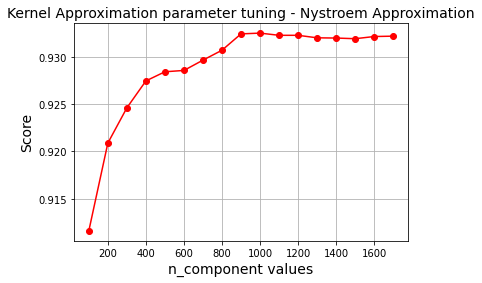

In [ ]:
nystroem_scores = [0.91159, 0.920879, 0.92461, 0.927459, 0.928428, 0.928569, 0.92966, 0.93071, 0.93244, 0.932523, 0.932289, 0.932289, 0.9320235, 0.932, 0.931929, 0.93216, 0.9322]
nystroem_values = np.arange(100,1800,100)
  
plt.plot(nystroem_values, nystroem_scores, color='red', marker='o')
plt.title('Kernel Approximation parameter tuning - Nystroem Approximation', fontsize=14)
plt.xlabel('n_component values', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()

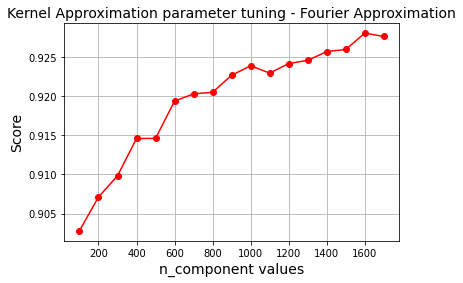

In [ ]:
fourier_scores = [0.9028, 0.9071, 0.90981, 0.91456438, 0.91458, 0.91933, 0.9202538, 0.920457, 0.92263, 0.923833, 0.9229, 0.9241145, 0.92452, 0.925646, 0.925912, 0.928, 0.92756885]
fourier_values = np.arange(100,1800,100)
  
plt.plot(fourier_values, fourier_scores, color='red', marker='o')
plt.title('Kernel Approximation parameter tuning - Fourier Approximation', fontsize=14)
plt.xlabel('n_component values', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.grid(True)
plt.show()

In [ ]:
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1,n_components=1000)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1, n_components=1000)
fourier_approx_svm = Pipeline(
    [('countVec',CountVectorizer()),('tfidf', TfidfTransformer()),("feature_map", feature_map_fourier), ("svm", LinearSVC())]
)

nystroem_approx_svm = Pipeline(
    [('countVec',CountVectorizer()),
     ('tfidf', TfidfTransformer()) ,
     ("feature_map", feature_map_nystroem), 
     ("svm", LinearSVC())]
)



Nystroem

In [ ]:
nystroem_approx_svm

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map',
                 Nystroem(gamma=0.2, n_components=1000, random_state=1)),
                ('svm', LinearSVC())])

In [ ]:
nystroem_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map',
                 Nystroem(gamma=0.2, n_components=1000, random_state=1)),
                ('svm', LinearSVC())])

In [ ]:
# pickle.dump(nystroem_approx_svm,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/'+'nystroem_n_comp{}'.format(1000),'wb'))

Fourier

In [ ]:
fourier_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map',
                 RBFSampler(gamma=0.2, n_components=1000, random_state=1)),
                ('svm', LinearSVC())])

In [ ]:
# pickle.dump(fourier_approx_svm,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/'+'fourier_n_comp{}'.format(1000),'wb'))

SVM RBF

In [ ]:
svm_rbf.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SVC())])

In [ ]:
# pickle.dump(svm_rbf,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/svm-test-train-count_vec_pipeline.pkl','wb'))

SGD

In [ ]:
feature_map_fourier = RBFSampler(gamma=0.2, random_state=1,n_components=1000)
feature_map_nystroem = Nystroem(gamma=0.2, random_state=1, n_components=1000)
sgd_fourier_approx_svm = Pipeline(
    [('countVec',count_vect),('tfidf', TfidfTransformer()),("feature_map", feature_map_fourier), ("sgd", SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6))]
)

sgd_nystroem_approx_svm = Pipeline(
    [('countVec',count_vect),('tfidf', TfidfTransformer()),("feature_map", feature_map_nystroem), ("sgd", SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6))]
)

sgdSVM = Pipeline(
    [('countVec',count_vect),('tfidf', TfidfTransformer()), ("sgd", SGDClassifier(loss='hinge', penalty='l2', epsilon=4, alpha=1e-6))]
)

In [ ]:
sgdSVM.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('sgd', SGDClassifier(alpha=1e-06, epsilon=4))])

In [ ]:
# pickle.dump(sgdSVM,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgdSVM-test-train-count_vec_pipeline.pkl','wb'))

In [ ]:
sgd_nystroem_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map',
                 Nystroem(gamma=0.2, n_components=1000, random_state=1)),
                ('sgd', SGDClassifier(alpha=1e-06, epsilon=4))])

In [ ]:
# pickle.dump(sgd_nystroem_approx_svm,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_nystroem_approx_svm-test-train-count_vec_pipeline.pkl','wb'))

In [ ]:
sgd_fourier_approx_svm.fit(X.comment_text.to_numpy(), Y.to_numpy().ravel())

Pipeline(steps=[('countVec', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('feature_map',
                 RBFSampler(gamma=0.2, n_components=1000, random_state=1)),
                ('sgd', SGDClassifier(alpha=1e-06, epsilon=4))])

In [ ]:
# pickle.dump(sgd_fourier_approx_svm,open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_fourier_approx_svm-test-train-count_vec_pipeline.pkl','wb'))

# Testing on Model

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/test.csv')
y_test = pd.read_csv('/content/drive/MyDrive/NLP_Project_IITB/Project/jigsaw-toxic-comment-classification-challenge/test_labels.csv')
y_test.head(3)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1


In [ ]:
x_test = transform_x(test_df)

In [ ]:
df_col_merged = merge(x_test,y_test)
df_col_merged.head()

,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Yo bitch Ja Rule is more succesful then youll ...,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,From RfC The title is fine as it is IMO,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,Sources Zawe Ashton on Lapland,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,If you have look back at the source the inform...,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,dont anonymously edit articles at all,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test_df = drop_faulty_rows(df_col_merged)

In [ ]:
x_test = test_df['comment_text']
y_test = combine_labels(test_df)

In [ ]:
x_test.head()

5     Thank you for understanding think very highly ...
7                        Dear god this site is horrible
11    Somebody will invariably try to add Religion R...
13    It says it right there that it IS type The Typ...
14    Before adding new product to the list make sur...
Name: comment_text, dtype: object

In [ ]:
y_test.head()

,Toxic
0,0
1,0
2,0
3,0
4,0


Testing approximate kernels

Linear SVM

In [ ]:
linearSVM = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/linearSVM_countvec_tfidf.pkl','rb'))

In [ ]:
y_pred = linearSVM.predict(x_test.to_numpy())
print(classification_report(y_test.to_numpy().ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     57735
           1       0.58      0.81      0.68      6243

    accuracy                           0.92     63978
   macro avg       0.78      0.87      0.82     63978
weighted avg       0.94      0.92      0.93     63978



Nystroem

In [ ]:
nystroem_approx_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/'+'nystroem_n_comp{}'.format(1000),'rb'))

In [ ]:
y_pred = nystroem_approx_svm.predict(x_test.to_numpy())
print(classification_report(y_test.to_numpy().ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     57735
           1       0.68      0.58      0.63      6243

    accuracy                           0.93     63978
   macro avg       0.82      0.78      0.80     63978
weighted avg       0.93      0.93      0.93     63978



Fourier

In [ ]:
fourier_approx_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/'+'fourier_n_comp{}'.format(1000),'rb'))

In [ ]:
y_pred = fourier_approx_svm.predict(x_test.to_numpy())
print(classification_report(y_test.to_numpy().ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     57735
           1       0.75      0.33      0.46      6243

    accuracy                           0.92     63978
   macro avg       0.84      0.66      0.71     63978
weighted avg       0.91      0.92      0.91     63978



RBF SVM

In [ ]:
svm_rbf = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/svm-test-train-count_vec_pipeline.pkl','rb'))

Caution takes time

In [ ]:
y_pred = svm_rbf.predict(x_test)

In [ ]:
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     57735
           1       0.59      0.75      0.66      6243

    accuracy                           0.92     63978
   macro avg       0.78      0.85      0.81     63978
weighted avg       0.93      0.92      0.93     63978



SGD with and without kernel approximations

Simple SGD with hinge loss and l2 regularisation

In [ ]:
sgdSVM = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgdSVM-test-train-count_vec_pipeline.pkl','rb'))

In [ ]:
y_pred = sgdSVM.predict(x_test.to_numpy())
print(classification_report(y_test.to_numpy(), y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     57735
           1       0.56      0.82      0.66      6243

    accuracy                           0.92     63978
   macro avg       0.77      0.87      0.81     63978
weighted avg       0.94      0.92      0.93     63978



SGD with kernel approximation

Nystroem

In [ ]:
sgd_nystroem_approx_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_nystroem_approx_svm-test-train-count_vec_pipeline.pkl','rb'))

In [ ]:
y_pred = sgd_nystroem_approx_svm.predict(x_test.to_numpy())
print(classification_report(y_test.to_numpy().ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96     57735
           1       0.72      0.54      0.62      6243

    accuracy                           0.93     63978
   macro avg       0.83      0.76      0.79     63978
weighted avg       0.93      0.93      0.93     63978



Fourier

In [ ]:
sgd_fourier_approx_svm = pickle.load(open('/content/drive/MyDrive/NLP_Project_IITB/Project/models/sgd_fourier_approx_svm-test-train-count_vec_pipeline.pkl','rb'))

In [ ]:
y_pred = sgd_fourier_approx_svm.predict(x_test.to_numpy()) 
print(classification_report(y_test.to_numpy().ravel(), y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     57735
           1       0.79      0.31      0.45      6243

    accuracy                           0.92     63978
   macro avg       0.86      0.65      0.70     63978
weighted avg       0.92      0.92      0.91     63978



## Custom Prediction

In [ ]:
def prediction(model, sent):
    sent = preprocess_text(sent)
    res = model.predict(np.array([sent]))
    if res[0] == 1:
        return "Toxic"
    return "Not Toxic"

Give a toxic sentence below

In [ ]:
inp_sent = "---give a toxic sentence--"

In [ ]:
print('Linear SVM:',prediction(linearSVM, inp_sent))
print('Linear SVM Nystroem:',prediction(nystroem_approx_svm, inp_sent))
print('Linear SVM Fourier:',prediction(fourier_approx_svm, inp_sent))
print('RBF SVM:',prediction(svm_rbf, inp_sent))

Linear SVM: Toxic
Linear SVM Nystroem: Toxic
Linear SVM Fourier: Not Toxic
RBF SVM: Toxic


In [ ]:
print('SVM SGD:',prediction(sgdSVM, inp_sent))
print('SVM SGD Nystroem:',prediction(sgd_nystroem_approx_svm, inp_sent))
print('SVM SGD Fourier:',prediction(sgd_fourier_approx_svm, inp_sent))


SVM SGD: Toxic
SVM SGD Nystroem: Toxic
SVM SGD Fourier: Not Toxic


# Nystroem kernel approximation decision surface Analysis

In [ ]:
xt = x_test.to_numpy()
yt = y_test.to_numpy().ravel()

randomize = np.where(yt==0)
np.random.shuffle(randomize)
x0 = xt[randomize]
y0 = yt[randomize]

randomize = np.where(yt==1)
np.random.shuffle(randomize)
x1 = xt[randomize]
y1 = yt[randomize]

x0_train,x0_test, y0_train, y0_test = train_test_split(x0,y0,test_size=0.3,shuffle=True,random_state=42)
x1_train,x1_test, y1_train, y1_test = train_test_split(x1,y1,test_size=0.3,shuffle=True,random_state=42)

n1 = len(y1_train)
n2 = len(y1_test)
xbalanced_train = np.hstack((x0_train[:n1], x1_train))
ybalanced_train = np.hstack((y0_train[:n1], y1_train))

xbalanced_test = np.hstack((x0_test[:n2], x1_test))
ybalanced_test = np.hstack((y0_test[:n2], y1_test))

x2 = xbalanced_train
y2 = ybalanced_train

x3 = xbalanced_test
y3 = ybalanced_test

In [ ]:
np.unique(ybalanced_test, return_counts=True)

(array([0, 1]), array([1873, 1873]))

In [ ]:
np.unique(ybalanced_train, return_counts=True)

(array([0, 1]), array([4370, 4370]))

In [ ]:
for name, transform in nystroem_approx_svm.steps[:-1]:
    print(name)
    if transform is not None:
        xbalanced_train = transform.transform(xbalanced_train)

countVec
tfidf
feature_map


In [ ]:
pca = PCA(n_components=3).fit(xbalanced_train)
xbalanced_train = pca.transform(xbalanced_train)

In [ ]:
for name, transform in nystroem_approx_svm.steps[:-1]:
    print(name)
    if transform is not None:
        xbalanced_test = transform.transform(xbalanced_test)

countVec
tfidf
feature_map


In [ ]:
pca = PCA(n_components=3).fit(xbalanced_test)
xbalanced_test = pca.transform(xbalanced_test)

## Side/ Inclined Angle View

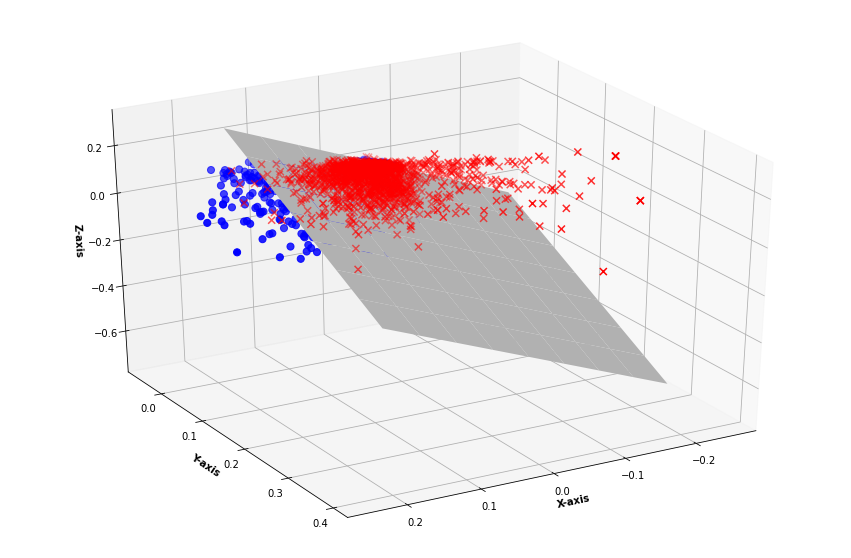

In [ ]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d
%matplotlib inline


X = xbalanced_train 
Y = ybalanced_train


clf = LinearSVC()
clf.fit(X,Y)

X = xbalanced_test 
Y = ybalanced_test

# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]


x,y = np.meshgrid(np.linspace(-0.25,0.15,9),np.linspace(-0.05,0.30,8))

fig = plt.figure(figsize=(15,10))

ax  = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')

ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=50, marker='o', c='blue')
ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2], s=50, marker='x', c='red')
ax.plot_surface(x, y, z(x,y), color='white')
ax.view_init(30, 60)
plt.show()

## Front View

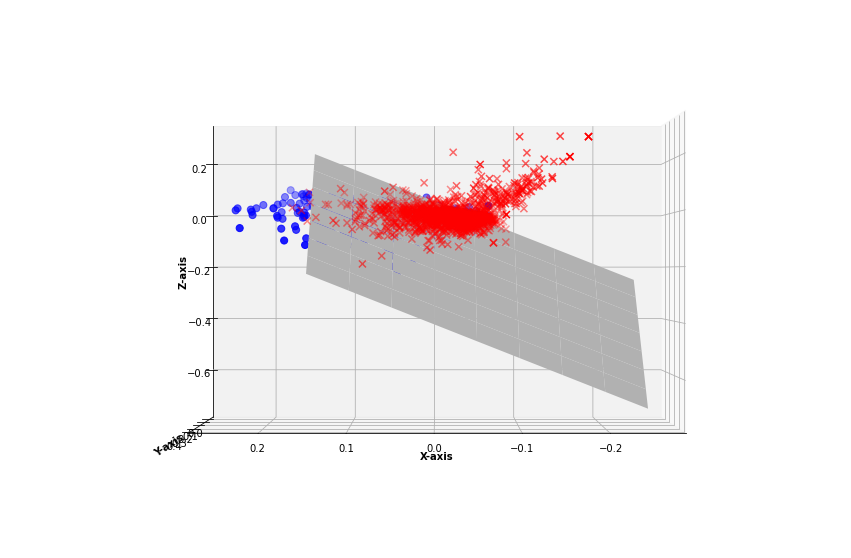

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))

ax  = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')

ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=50, marker='o', c='blue')
ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2], s=50, marker='x', c='red')
ax.plot_surface(x, y, z(x,y), color='white')
ax.view_init(0, 90)
plt.show()

# Fourier kernel approximation decision surface Analysis

In [ ]:

xbalanced_train = x2
ybalanced_train = y2

xbalanced_test = x3
ybalanced_test = y3


In [ ]:
for name, transform in fourier_approx_svm.steps[:-1]:
    print(name)
    if transform is not None:
        xbalanced_train = transform.transform(xbalanced_train)

countVec
tfidf
feature_map


In [ ]:
pca = PCA(n_components=3).fit(xbalanced_train)
xbalanced_train = pca.transform(xbalanced_train)

In [ ]:
for name, transform in fourier_approx_svm.steps[:-1]:
    print(name)
    if transform is not None:
        xbalanced_test = transform.transform(xbalanced_test)

countVec
tfidf
feature_map


In [ ]:
pca = PCA(n_components=3).fit(xbalanced_test)
xbalanced_test = pca.transform(xbalanced_test)

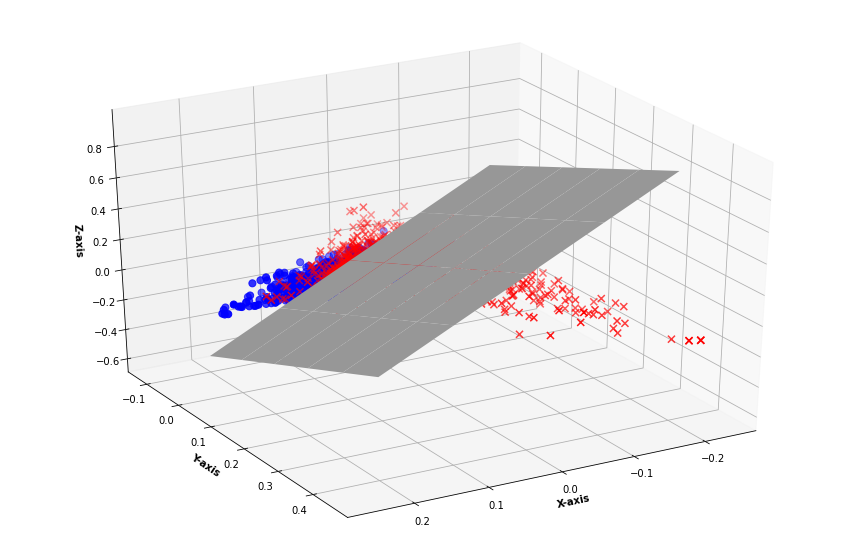

In [ ]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d
%matplotlib inline


X = xbalanced_train 
Y = ybalanced_train


clf = LinearSVC()
clf.fit(X,Y)

X = xbalanced_test 
Y = ybalanced_test

# The equation of the separating plane is given by all x so that np.dot(svc.coef_[0], x) + b = 0.
# Solve for w3 (z)
z = lambda x,y: (-clf.intercept_[0]-clf.coef_[0][0]*x -clf.coef_[0][1]*y) / clf.coef_[0][2]


x,y = np.meshgrid(np.linspace(-0.2,0.2,5),np.linspace(-0.1,0.4,6))

fig = plt.figure(figsize=(15,10))

ax  = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')

ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=50, marker='o', c='blue')
ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2], s=50, marker='x', c='red')
ax.plot_surface(x, y, z(x,y), color='white')
ax.view_init(30, 60)
plt.show()

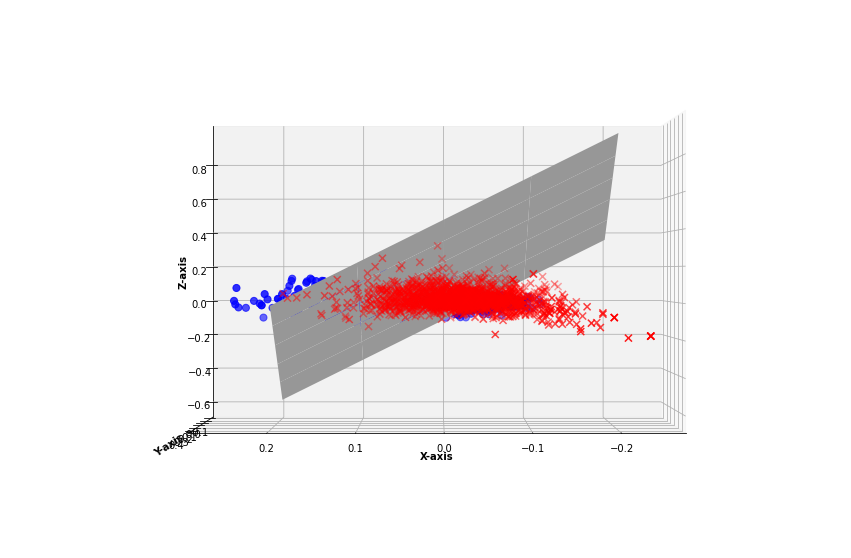

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))

ax  = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis', fontweight ='bold')
ax.set_ylabel('Y-axis', fontweight ='bold')
ax.set_zlabel('Z-axis', fontweight ='bold')

ax.scatter(X[Y==0,0], X[Y==0,1], X[Y==0,2], s=50, marker='o', c='blue')
ax.scatter(X[Y==1,0], X[Y==1,1], X[Y==1,2], s=50, marker='x', c='red')
ax.plot_surface(x, y, z(x,y), color='white')
ax.view_init(0, 90)
plt.show()